In [4]:
from sklearn import datasets
import numpy as np
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

<h4> Zadanie1 (1 pkt): Rozważ dane Medical‑Abstracts‑TC‑Corpus — zbiór abstraktów medycznych z 5 klasami (nowotwory, choroby układu pokarmowego, nerwowego, sercowo‑naczyniowego i „ogólne stany patologiczne”). W oparciu o metodę SVM zbuduj klasyfikator na reprezentacjach TF-IDF tych abstraktów. Poniżej pare uwag:
    
- zbiory: treningowy i testowy są już wydzielone
- potestuj różne hiperparametry (zarówno dla SVM jak i TF - IDF, np. max_features)
- finalny raport klasyfikacji na zbiorze testowym powinien wynosić co najmniej 50 \% (a najlepiej więcej) dla f1-score dla każdej kategorii.
- być może przydatne będzie dogenerowanie nowych danych na podstawie istniejących przykładów (balansowanie danych)

https://huggingface.co/datasets/TimSchopf/medical_abstracts

In [2]:
import pandas as pd

df = pd.read_csv("medical_tc_train.csv")
df_test = pd.read_csv("medical_tc_test.csv")
df_labels = pd.read_csv("medical_tc_labels.csv")

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_raw = df['medical_abstract']
X_test_raw = df_test['medical_abstract']
y = df['condition_label']
y_test = df_test['condition_label']

vectorizer = TfidfVectorizer(max_features=5000) #domyślnie normalizacja l2 (norma euklidesowa)
X = vectorizer.fit_transform(X_raw)
X_test = vectorizer.transform(X_test_raw)

print(X.shape)
print(X_test.shape)

(11550, 5000)
(2888, 5000)


1. Podstawowy model liniowy - wyniki zadowalające

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

svm = SVC(kernel='linear', C=1., random_state=42) 
svm.fit(X, y)

yfit = svm.predict(X_test)
print(classification_report(y_test, yfit, target_names=df_labels['condition_name']))

                                 precision    recall  f1-score   support

                      neoplasms       0.66      0.72      0.69       633
      digestive system diseases       0.52      0.47      0.49       299
        nervous system diseases       0.56      0.47      0.51       385
        cardiovascular diseases       0.65      0.68      0.66       610
general pathological conditions       0.48      0.48      0.48       961

                       accuracy                           0.57      2888
                      macro avg       0.57      0.56      0.57      2888
                   weighted avg       0.57      0.57      0.57      2888



1_2. Dodano class_weight 

wyniki nieznacznie lepsze

In [ ]:
svm1_2 = SVC(kernel='linear', C=1., class_weight='balanced', random_state=42) 
svm1_2.fit(X, y)

yfit = svm1_2.predict(X_test)
print(classification_report(y_test, yfit, target_names=df_labels['condition_name']))

                                 precision    recall  f1-score   support

                      neoplasms       0.67      0.73      0.70       633
      digestive system diseases       0.47      0.69      0.56       299
        nervous system diseases       0.51      0.66      0.57       385
        cardiovascular diseases       0.66      0.75      0.70       610
general pathological conditions       0.56      0.33      0.41       961

                       accuracy                           0.59      2888
                      macro avg       0.57      0.63      0.59      2888
                   weighted avg       0.59      0.59      0.57      2888



2. Zbalansowanie klas i grid search

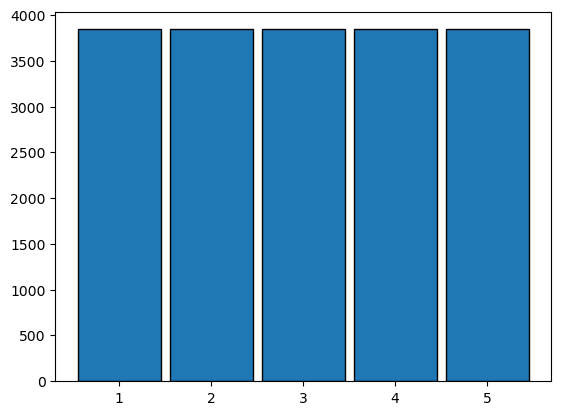

In [8]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)


plt.hist(y_res, bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], align='mid', rwidth=0.9, edgecolor='black')
plt.xticks([1, 2, 3, 4, 5]) 
plt.show()

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

svc = SVC(kernel = 'linear', random_state = 42)
model = Pipeline([('svc',svc)])

param_grid = {"svc__C": [0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(model, param_grid)
grid = grid.fit(X_res, y_res)

print(grid.best_params_)
print(grid.score(X_test, y_test))

{'svc__C': 1}
0.5695983379501385


In [6]:
svm2 = SVC(kernel='linear', C=1., random_state=42) 
svm2.fit(X_res, y_res)

yfit = svm2.predict(X_test)
print(classification_report(y_test, yfit, target_names=df_labels['condition_name']))

                                 precision    recall  f1-score   support

                      neoplasms       0.65      0.71      0.68       633
      digestive system diseases       0.45      0.66      0.54       299
        nervous system diseases       0.50      0.61      0.55       385
        cardiovascular diseases       0.64      0.71      0.68       610
general pathological conditions       0.54      0.34      0.42       961

                       accuracy                           0.57      2888
                      macro avg       0.56      0.61      0.57      2888
                   weighted avg       0.57      0.57      0.56      2888



nadal general pathological conditions są słabo klasyfikowane

3. Inne jądro - rbf

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

svc = SVC(kernel = 'rbf', random_state = 42, class_weight='balanced')
model = Pipeline([('svc',svc)])

param_grid = {"svc__C": [1, 5, 10, 50],
              "svc__gamma": [0.0001, 0.0005, 0.001, 0.005]}

grid = GridSearchCV(model, param_grid)
grid = grid.fit(X, y)

print(grid.best_params_)
print(grid.score(X_test, y_test))

{'svc__C': 50, 'svc__gamma': 0.005}
0.6038781163434903


In [12]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

svm3 = SVC(kernel='rbf', C=50, gamma=0.005, random_state=42, class_weight='balanced') 
svm3.fit(X, y)

yfit = svm3.predict(X_test)
print(classification_report(y_test, yfit, target_names=df_labels['condition_name']))

                                 precision    recall  f1-score   support

                      neoplasms       0.69      0.75      0.72       633
      digestive system diseases       0.49      0.71      0.58       299
        nervous system diseases       0.52      0.69      0.59       385
        cardiovascular diseases       0.67      0.75      0.71       610
general pathological conditions       0.58      0.35      0.43       961

                       accuracy                           0.60      2888
                      macro avg       0.59      0.65      0.61      2888
                   weighted avg       0.61      0.60      0.59      2888



niewiele pomogło, spróbujmy tych parametrach ale z innym balasowaniem

In [ ]:
svm3_2 = SVC(kernel='rbf', C=50, gamma=0.005, random_state=42) 
svm3_2.fit(X_res, y_res)

yfit = svm3_2.predict(X_test)
print(classification_report(y_test, yfit, target_names=df_labels['condition_name']))

                                 precision    recall  f1-score   support

                      neoplasms       0.68      0.73      0.70       633
      digestive system diseases       0.47      0.69      0.56       299
        nervous system diseases       0.52      0.66      0.58       385
        cardiovascular diseases       0.66      0.75      0.71       610
general pathological conditions       0.57      0.35      0.44       961

                       accuracy                           0.59      2888
                      macro avg       0.58      0.64      0.60      2888
                   weighted avg       0.60      0.59      0.58      2888



In [11]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

svm3_3 = SVC(kernel='rbf', C=50, gamma=0.005, random_state=42) 
svm3_3.fit(X, y)

yfit = svm3_3.predict(X_test)
print(classification_report(y_test, yfit, target_names=df_labels['condition_name']))

                                 precision    recall  f1-score   support

                      neoplasms       0.69      0.73      0.71       633
      digestive system diseases       0.58      0.46      0.52       299
        nervous system diseases       0.59      0.43      0.50       385
        cardiovascular diseases       0.66      0.69      0.67       610
general pathological conditions       0.49      0.54      0.51       961

                       accuracy                           0.59      2888
                      macro avg       0.60      0.57      0.58      2888
                   weighted avg       0.59      0.59      0.59      2888



najlepsze wyniki dla hiperparametrów z grid search ale bez balansowania klas

<h4> Zadanie2 (1+2 pkt): Rozważ sekwencje intronów i eksonów z ludzkiego chromosomu 1. 

- Wydziel zbiór treningowy i testowy
- Zaproponuj reprezentacje dla tych sekwencji (np. częstości wybranych k-merów, inne pomysły mile widziane), zastanów się czy warto normalizować/standaryzować dane
- Zbuduj klasyfikator w oparciu o SVM, na zbiorze testowym f1-score dla każdej kategorii powinno wynosić co najmniej 90 \%
- Spróbuj zinterpretować zbudowany model - wksaż które cechy sekwencji najbardziej decydują o tym, że dana sekwencja jest eksonem/intronem - np. częstości wybranych k-merów. Możesz wykorzystać algorytm RFE (https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html).

Druga część zadania (stanowiąca rozszerzenie pierwszej części) będzie polegać na stworzeniu modelu (w oparciu o SVM) który dla sekwencji składajacej się z intronów oraz eksonów rozpozna miejsca zmiany typu sekwencji genu - złożonej zarówno z intronów jak i eksonów EEEEEIIIIIIEEEEEIIII - czyli powie nam gdzie kończą/zaczynają się eksony. W tym przypadku możesz np. poruszać się oknem o zadanej długości i zastosować model z części I - być może warto narysować odpowiedni wykres. Inne pomysły bardzo mile widziane! (liczę na waszą kreatywność :)). Wyznaczenie dokładnego miejsca zmiany może być trudne, jako kryterium przyjmij, np. +-kilkanaście/kilkadziesiąt pozycji jako próg tolerancji. Zaproponuj odpowiednią fukcję kosztu/miarę oceny.

- To zadanie (zadanie2) proszę opracować także w formie raportu - 1 strona pdf. Na następnych zajęciach poprosze 2/3 osoby o przedstawienie swojego rozwiązania - opisu algorytmu, interpretacji modelu oraz ewentualnie kodu.

Cześć I

In [222]:
import random
import random
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

In [223]:
#prepare data
def get_seqs(file):
    seqs = []
    with open(file, 'r') as f:
        for line in f:
            if not line.startswith('>'):
                seqs.append(line.strip())
    return seqs

introns, exons = get_seqs('introns.txt'), get_seqs('exons.txt')

print(f"Liczba intronów: {len(introns)}\nLiczba eksonów: {len(exons)}")  

def get_sets(introns, exons):
    seqs = introns + exons
    labs = [0]*len(introns) + [1]*len(exons)

    pairs = list(zip(seqs, labs))

    random.shuffle(pairs, random.seed(42))

    shuffled_seqs, shuffled_labels = zip(*pairs) # * unzip

    return list(shuffled_seqs), list(shuffled_labels)

X_seqs, y_labs = get_sets(introns, exons)

print(f"Liczba sekwencji w zbiorze: {len(X_seqs)}")
print(f"Liczba etykiet w zbiorze: {len(y_labs)}")

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X_seqs, y_labs, test_size=0.2, random_state=42)

Liczba intronów: 261
Liczba eksonów: 400
Liczba sekwencji w zbiorze: 661
Liczba etykiet w zbiorze: 661


In [224]:
#check class distribution
print(f' Intron [0]: {y_train.count(0)} | Ekson [1]: {y_train.count(1)}')
print(f' Intron [0]: {y_test.count(0)} | Ekson [1]: {y_test.count(1)}')

 Intron [0]: 211 | Ekson [1]: 317
 Intron [0]: 50 | Ekson [1]: 83


In [225]:
def kmer_str(seq, k=5): #najlepsze wyniki dla k=5
    """
    Dzieli sekwencję na k-mery i zwraca je jako pojedynczy ciąg znaków rozdzielony spacjami.
    """
    N = len(seq)
    k_mers_list = [seq[i:(i + k)] for i in range(N - k + 1)]
    return ' '.join(k_mers_list)

#przygotowanie list k-merów dla każdej sekwencji  w zbiorze treningowym i testowym
X_train_kmer = [kmer_str(seq) for seq in X_train]
X_test_kmer = [kmer_str(seq) for seq in X_test]

#wektoryzacja k-merów
vectorizer = TfidfVectorizer() 
#dopasowanie wektoryzatora TYLKO na danych treningowych
X_train_vectorized = vectorizer.fit_transform(X_train_kmer)
#transformacja danych testowych (używając słownika z treningowego)
X_test_vectorized = vectorizer.transform(X_test_kmer)

#Trening SVM
from sklearn.svm import LinearSVC
svm_model = LinearSVC(dual=False, random_state=42) #svm(kernel='linear') nie działa z rfe

svm_model.fit(X_train_vectorized, y_train)

y_pred = svm_model.predict(X_test_vectorized)
print(classification_report(y_test, y_pred, target_names=['Intron (0)', 'Ekson (1)']))


              precision    recall  f1-score   support

  Intron (0)       0.94      0.98      0.96        50
   Ekson (1)       0.99      0.96      0.98        83

    accuracy                           0.97       133
   macro avg       0.96      0.97      0.97       133
weighted avg       0.97      0.97      0.97       133



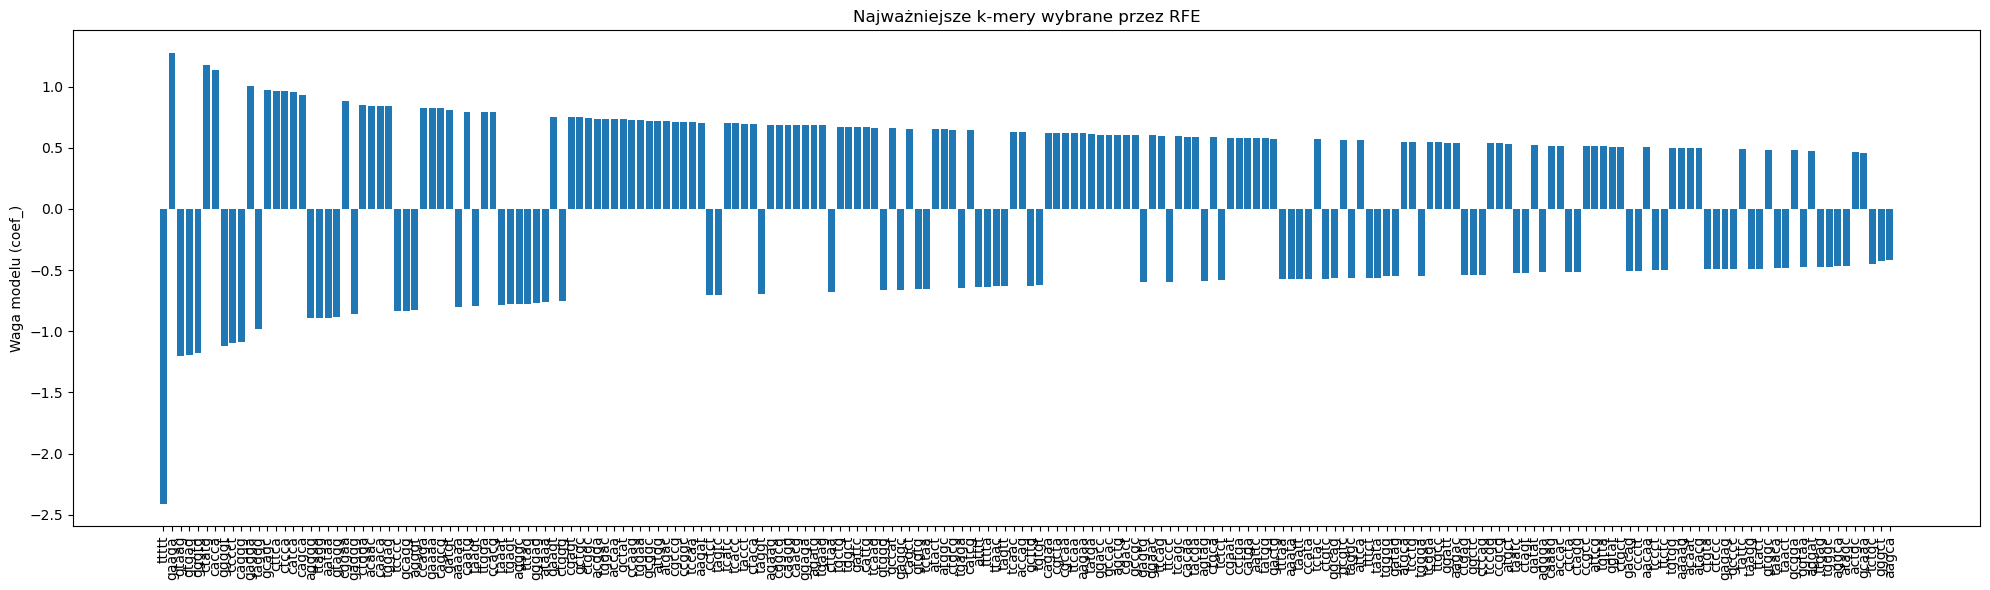

Najważniejsze k-mery:
['ttttt', 'gaaga', 'gtaag', 'gtgag', 'gggtg', 'ctatg', 'cacca', 'ggggt', 'cccct', 'caggg', 'gagga', 'taggg', 'gcagc', 'cttca', 'ctcca', 'catca', 'cagca', 'agggg', 'ttagg', 'aataa', 'gtagg', 'cggaa', 'gaggg', 'ctgga', 'acaac', 'caaca', 'tggag', 'tcccc', 'gcagg', 'agggt', 'ccaga', 'gaaaa', 'cagcg', 'gatgt', 'aaaaa', 'caatg', 'taagt', 'ttgga', 'ccacg', 'taaat', 'tgagt', 'agggc', 'tttag', 'gggag', 'ataaa', 'gaagt', 'ctggg', 'cgagt', 'gctgc', 'ctggc', 'acgga', 'tggac', 'accaa', 'gctat', 'ccaag', 'tggaa', 'gcggc', 'attgg', 'atgac', 'cgccg', 'ccggc', 'tccaa', 'aagat', 'cctct', 'tagtc', 'tcatc', 'tcacc', 'tacct', 'ctaca', 'taggt', 'agaag', 'cggcg', 'caagg', 'caacg', 'ggaga', 'agatg', 'tgaag', 'cttaa', 'tgctg', 'tggct', 'gattc', 'cattg', 'tcaag', 'gtggg', 'gccat', 'gaggc', 'cagct', 'gtgtg', 'tctaa', 'atact', 'atggc', 'ctgcg', 'tgaga', 'catcg', 'atttt', 'tttta', 'ttaac', 'tagtt', 'tcaac', 'accag', 'gcttg', 'tgtgt', 'cagaa', 'cgcta', 'cgcaa', 'ttcaa', 'aagaa', 'tatga', 'ggac

In [226]:
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

selector = RFE(svm_model, n_features_to_select=200, step=0.1) #usuwamy kmery az zostanie 200 najważniejszych; step - procent cech usuwanych w każdej iteracji
selector.fit(X_train_vectorized, y_train)

# Maski cech wybranych
selected_mask = selector.support_
selected_features = np.array(vectorizer.get_feature_names_out())[selected_mask]

# Wagi cech z modelu wewnątrz RFE
model = selector.estimator_
weights = model.coef_.flatten()

#sortujemy malejąco wg wagi bezwzględnej
sorted_idx = np.argsort(np.abs(weights))[::-1]
top_features = selected_features[sorted_idx]
top_weights = weights[sorted_idx]

#wykres: ujemna waga - introny, dodatnia - eksony
plt.figure(figsize=(20,6))
plt.bar(top_features, top_weights)
plt.xticks(rotation=90)
plt.title("Najważniejsze k-mery wybrane przez RFE")
plt.ylabel("Waga modelu (coef_)")
plt.tight_layout()
plt.show()

# najwazniejsze kmery do listy
best_kmers = []
for f, w in zip(top_features, top_weights):
    best_kmers.append(f)
print(f"Najważniejsze k-mery:\n{best_kmers}")

In [227]:
#sprawdzenie accuracy dla modelu po rfe (najlepsze dla 200 kmerów)
X_train_selected = X_train_vectorized[:, selected_mask]
X_test_selected = X_test_vectorized[:, selected_mask]

svm_rfe = LinearSVC(dual=False, random_state=42)
svm_rfe.fit(X_train_selected, y_train)

y_pred_rfe = svm_rfe.predict(X_test_selected)
print(classification_report(y_test, y_pred_rfe, target_names=['Intron (0)', 'Ekson (1)']))


              precision    recall  f1-score   support

  Intron (0)       0.98      0.96      0.97        50
   Ekson (1)       0.98      0.99      0.98        83

    accuracy                           0.98       133
   macro avg       0.98      0.97      0.98       133
weighted avg       0.98      0.98      0.98       133



Część II

In [232]:
import random

def generate_random_gene(X_test, y_test, min_fragments=5, max_fragments=20):
    """
    Generuje losową sekwencję genu z eksonów i intronów w losowej kolejności.
    min_fragments, max_fragments - określają minimalną i maksymalną liczbę fragmentów E/I.
    """

    exons = [seq for seq, label in zip(X_test, y_test) if label == 1]
    introns = [seq for seq, label in zip(X_test, y_test) if label == 0]

    seq = ""
    true_labels = []

    #liczba fragmentów w genie
    num_fragments = random.randint(min_fragments, max_fragments)

    #kolejność fragmentów
    for _ in range(num_fragments):
        if random.random() < 0.5:  # 50% szans na ekson lub intron
            frag = random.choice(exons).strip()
            seq += frag
            true_labels += [1] * len(frag) #ekson to 1
        else:
            frag = random.choice(introns).strip()
            seq += frag
            true_labels += [0] * len(frag) #intron to 0

    return seq, true_labels

In [ ]:
#BASIC
def predict_sliding_window(seq, window=200, step=10):
    preds = []

    for i in range(0, len(seq) - window + 1, step):
        window_seq = seq[i:i+window]
        kmers = kmer_str(window_seq)
        vector = vectorizer.transform([kmers])
        pred = svm_model.predict(vector)[0]
        preds.append((i, pred))  #pozycja startowa okna + predykcja
    return preds

def window_preds_to_positions(preds, seq_len, window=200, step=20):
    pos_pred = np.zeros(seq_len)

    for start, pred in preds:
        end = start + window
        pos_pred[start:end] += pred #dodaje 1/0 dla każdej pozycji

    #jeśli >0.5 → ekson
    pos_pred = pos_pred / np.max(pos_pred)
    binary_pred = (pos_pred > 0.5).astype(int)

    return binary_pred


#RFE
def predict_sliding_window_rfe(seq, window=200, step=10):
    preds = []

    for i in range(0, len(seq) - window + 1, step):
        window_seq = seq[i:i+window]
        kmers = kmer_str(window_seq)
        vector = vectorizer.transform([kmers])

        #ograniczamy do wybranych cech przez RFE
        vector_selected = vector[:, selected_mask]

        pred = selector.estimator_.predict(vector_selected)[0]  #używamy modelu po RFE
        preds.append((i, pred))
    return preds

def window_preds_to_positions_rfe(preds, seq_len, window=200, step=20, threshold=0.7):
    pos_pred = np.zeros(seq_len)

    for start, pred in preds:
        end = start + window
        pos_pred[start:end] += pred

    #normalizacja i progowanie
    pos_pred = pos_pred / np.max(pos_pred)
    binary_pred = (pos_pred > threshold).astype(int)

    return binary_pred

#PLOT
def plot(true_labels, position_preds):
    fig, axs = plt.subplots(2, 1, figsize=(20,6), sharex=True)

    #true
    axs[0].plot(true_labels, color='blue')
    axs[0].set_title("Prawdziwe oznaczenia E/I")
    axs[0].set_ylabel("E=1 / I=0")

    #pred
    axs[1].plot(position_preds, color='orange')
    axs[1].set_title("Predykcja modelu po RFE")
    axs[1].set_ylabel("E=1 / I=0")
    axs[1].set_xlabel("Pozycja w sekwencji")

    plt.tight_layout()
    plt.show()

#SIGMOID ACCURACY

k = 145.9
x = 0.0883

def sigmoid_accuracy(true_labels, preds, k=k, x0=x):
    """
    Znormalizowana liczba błędów z funkcją sigmoidalną.

    - k: stromość sigmoidy (większe -> ostrzej)
    - x0: próg, od którego zaczyna się spadek (domyślnie 0)
    - sharp_score: float w zakresie [0, 1]
    """
    true_labels = np.array(true_labels)
    preds = np.array(preds)
    
    #liczba błędów
    n_errors = np.sum(true_labels != preds)
    N = len(true_labels)
    
    #normalizacja błędów
    error_ratio = n_errors / N
    
    #funkcja sigmoid (1 = perfekcja, 0 = dużo błędów)
    sharp_score = 1 / (1 + np.exp(k * (error_ratio - x0)))
    return sharp_score

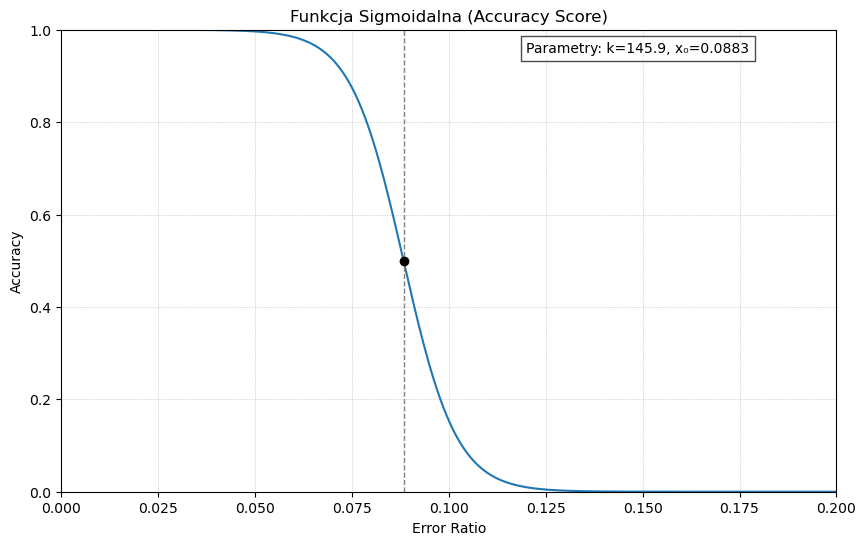

In [ ]:
#PLOT SIGMOID FUNCTION
def sigmoid(error_ratio, k=k, x0=x):
    return 1 / (1 + np.exp(k * (error_ratio - x0)))

error_ratios = np.linspace(0, 0.2, 500) #koncentrujemy się na zakresie 0-0.2, bo tam jest akcja
scores = sigmoid(error_ratios)

plt.figure(figsize=(10, 6))
plt.plot(error_ratios, scores)

x0_score = sigmoid(x0)
plt.axvline(x=x0, color='gray', linestyle='--', linewidth=1, label=f'Próg (x₀) = {x0}')
plt.plot(x0, x0_score, 'o', color='black')
plt.title('Funkcja Sigmoidalna (Accuracy Score)')
plt.xlabel('Error Ratio')
plt.ylabel('Accuracy')
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.xlim(0, 0.2) 
plt.ylim(0, 1) 
plt.text(0.12, 0.95, f'Parametry: k={k}, x₀={x0}', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
plt.show()

39914 GTAAGTATTTTTTTTAATGTATTTTGAAACAAGCTTGGGTTTATGGGTTTCACATTATAGTTCCTTTGGTCATTTTTAAAAGTCAGATTTATAAATAGAGTCAAAGGTGCTTTTTTTCTTTATGTAGTAAAACTTTTGATTTTGGTCTTCTGAAGGTGATGTTTTGTCATTAGTTTAGCATTTCTTGGTTAATAAACTCA
0.9136620395669959


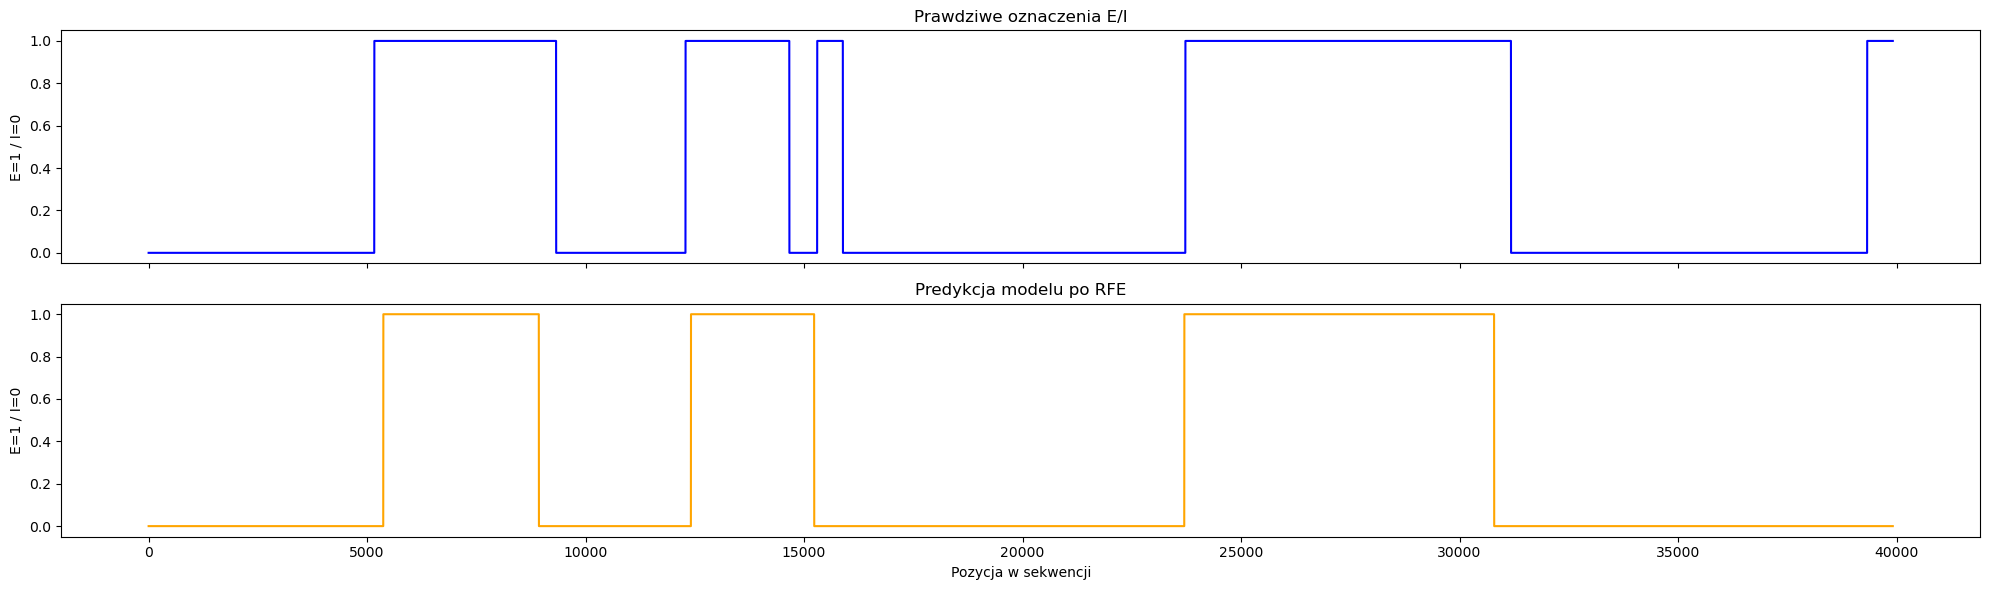

9.329237586041518e-06


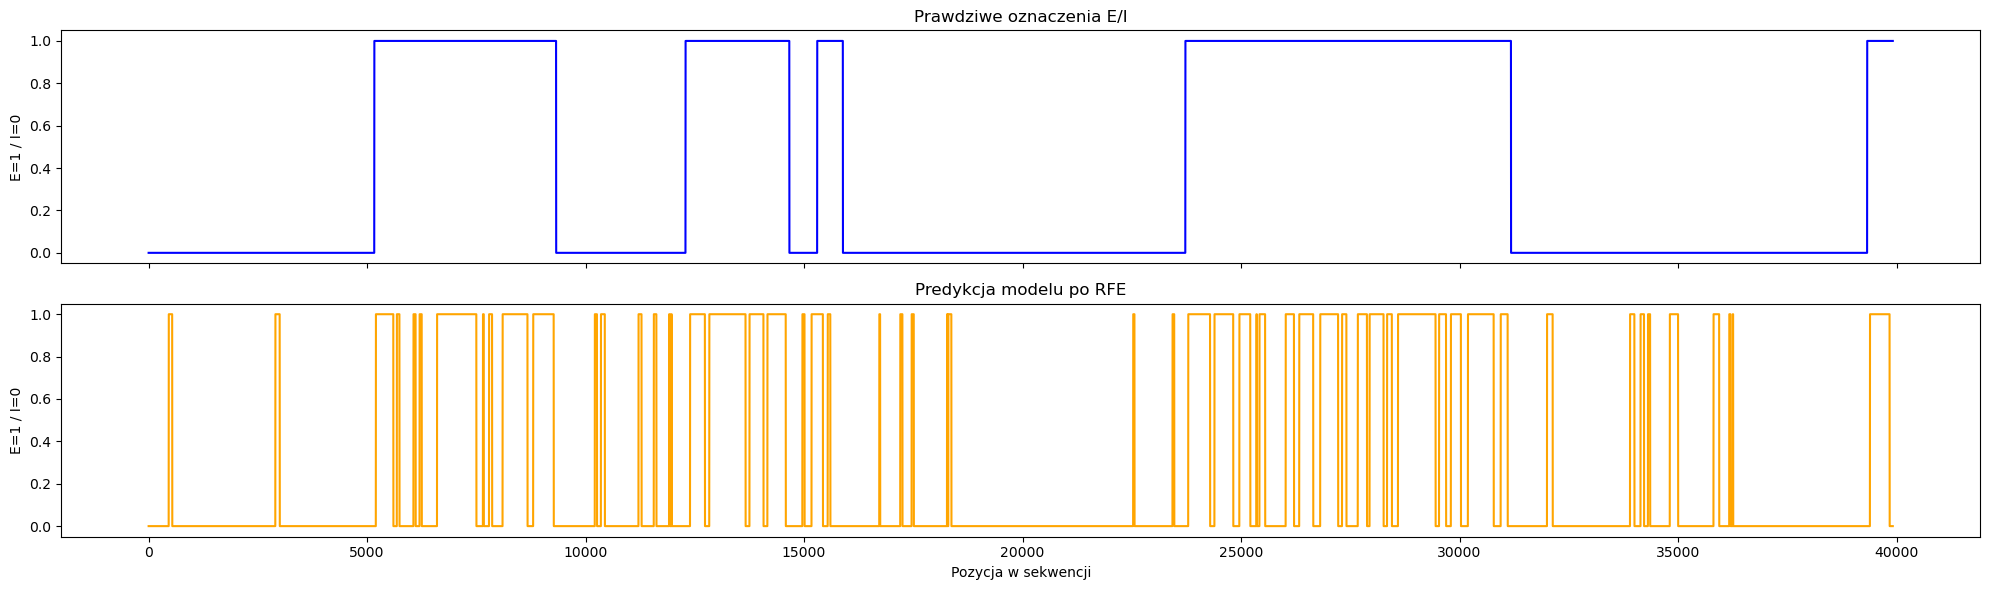

In [250]:
#Check to arbitrarily assess accuracy parameters

gene_seq, true_labels = generate_random_gene(X_test, y_test)
print(len(gene_seq), gene_seq[:200])

preds_rfe = predict_sliding_window_rfe(gene_seq, window=1000, step=10)
position_preds_rfe = window_preds_to_positions_rfe(preds_rfe, len(gene_seq), window=1000, step=10, threshold=0.7)
print(sigmoid_accuracy(true_labels, position_preds_rfe))
plot(true_labels, position_preds_rfe)

preds_rfe2 = predict_sliding_window_rfe(gene_seq, window=100, step=10)
position_preds_rfe2 = window_preds_to_positions_rfe(preds_rfe2, len(gene_seq), window=100, step=10, threshold=0.7)
print(sigmoid_accuracy(true_labels, position_preds_rfe2))
plot(true_labels, position_preds_rfe2)

Dopasowanie hiperparametrów - manualny grid search

BASIC

In [251]:
window_values = [500, 1000, 1500, 2000]
step_values = [10, 50, 100, 150, 200]

best_acc = 0
best_params = None

for w in window_values:
    for s in step_values:
        preds = predict_sliding_window(gene_seq, window=w, step=s)
        position_preds = window_preds_to_positions(preds, len(gene_seq))
        acc = sigmoid_accuracy(true_labels, position_preds)
        
        if acc > best_acc:
            best_acc = acc
            best_params = (w, s)

print("Best accuracy:", best_acc)
print("Best params:", best_params)

Best accuracy: 0.8540870879782798
Best params: (500, 50)


Check

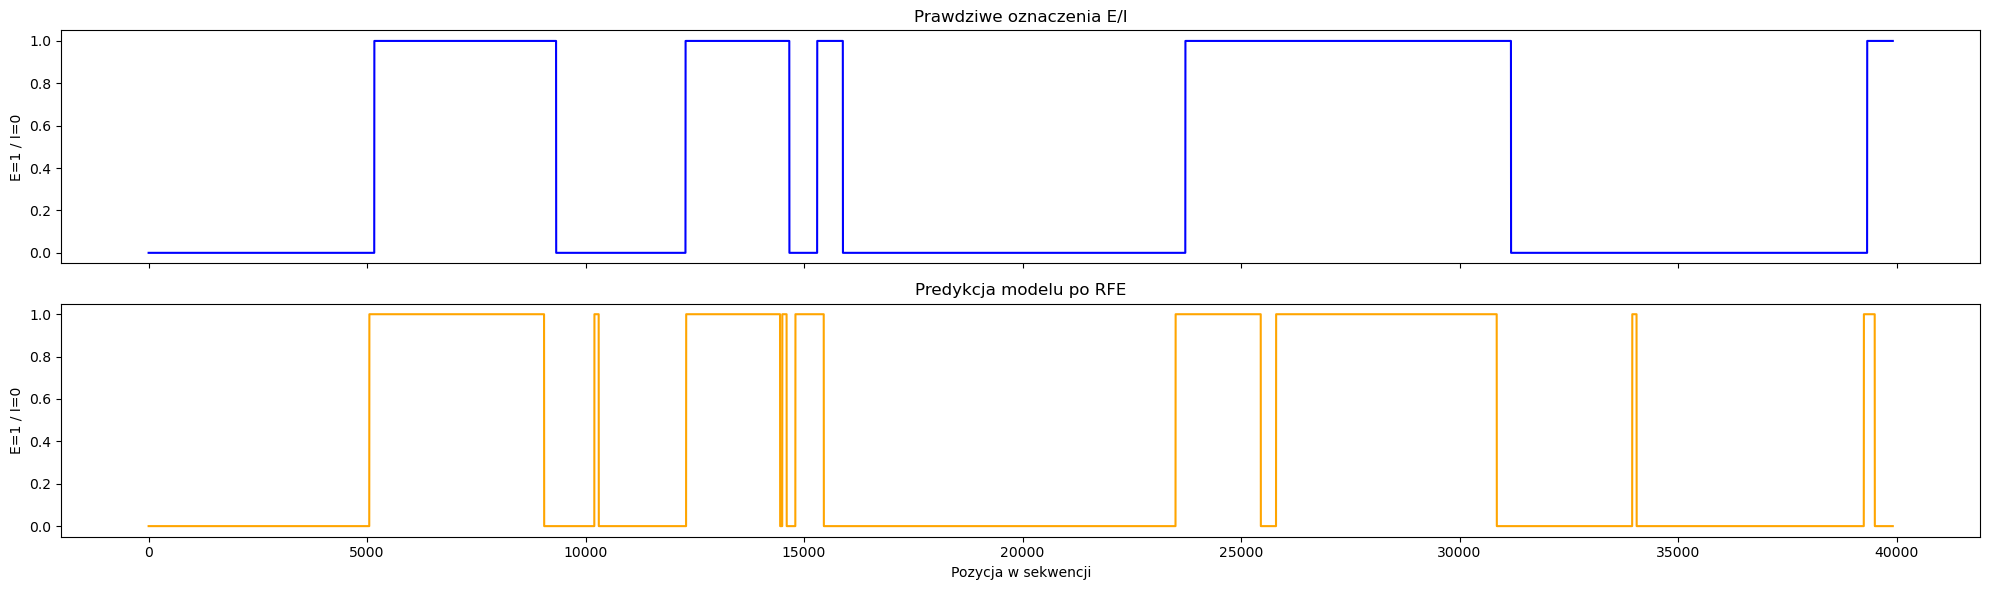

In [252]:
w, s = best_params
preds = predict_sliding_window(gene_seq, window=w, step=s)
position_preds = window_preds_to_positions(preds, len(gene_seq))
plot(true_labels, position_preds)

Check on random gene

80888 GTGAGGGGCGTGTGGGCAGAGGGGGTTTGGGACAGCAGGGTTTGTGCTAGGGGCTCTGGAGCCTGCCTTGGGTTCTTACAACCTCTCTAAAAAGCCAGGACTGCTCTCATCATTTCAATAGGGAGAAAACTGAGACTCAGAAAGAGAAAGGACTTGCCCTGGGTCGAATTGAAGGTTGGGAGCCTCTGAAGGCTTTTTTA
0.9802724169078656


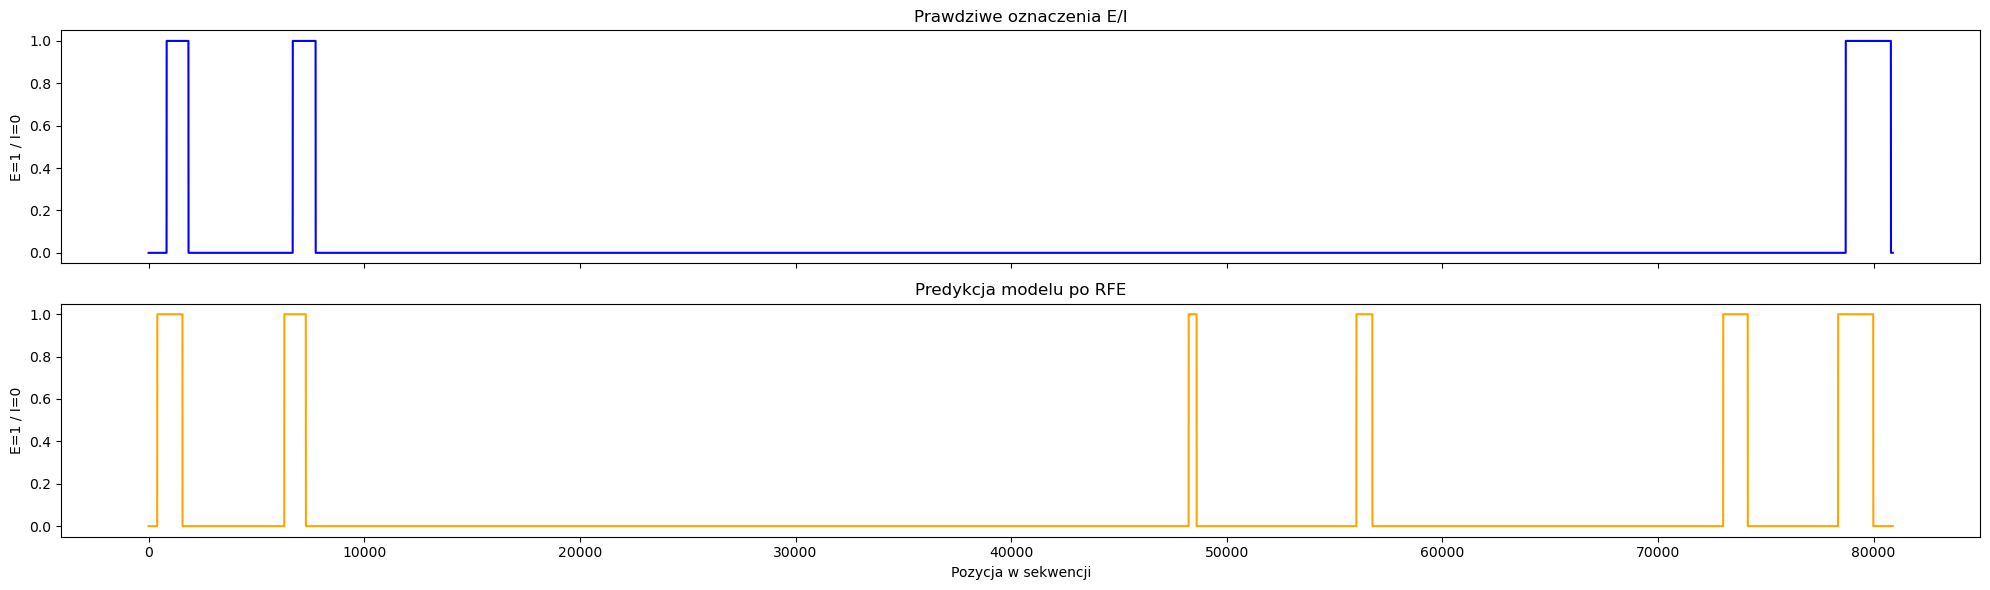

In [271]:
#check on random gene
gene_seq2, true_labels2 = generate_random_gene(X_test, y_test)
print(len(gene_seq2), gene_seq2[:200])

preds = predict_sliding_window(gene_seq2, window=w, step=s)
position_preds = window_preds_to_positions(preds, len(gene_seq2))
print(sigmoid_accuracy(true_labels2, position_preds))
plot(true_labels2, position_preds)

RFE

In [ ]:
thresholds = [0.5, 0.7, 0.9]

best_acc_rfe = 0
best_params_rfe = None

for w in window_values:
    for s in step_values:
        for t in thresholds:
            preds_rfe = predict_sliding_window_rfe(gene_seq, window=w, step=s)
            position_preds_rfe = window_preds_to_positions_rfe(preds_rfe, len(gene_seq), window=w, step=s, threshold=t)
            acc = sigmoid_accuracy(true_labels, position_preds_rfe)
            if acc > best_acc_rfe:
                best_acc_rfe = acc
                best_params_rfe = (w, s, t)

print("Best accuracy:", best_acc_rfe)
print("Best params:", best_params_rfe)

Best accuracy: 0.985563082259181
Best params: (1000, 10, 0.5)


Check

0.985563082259181


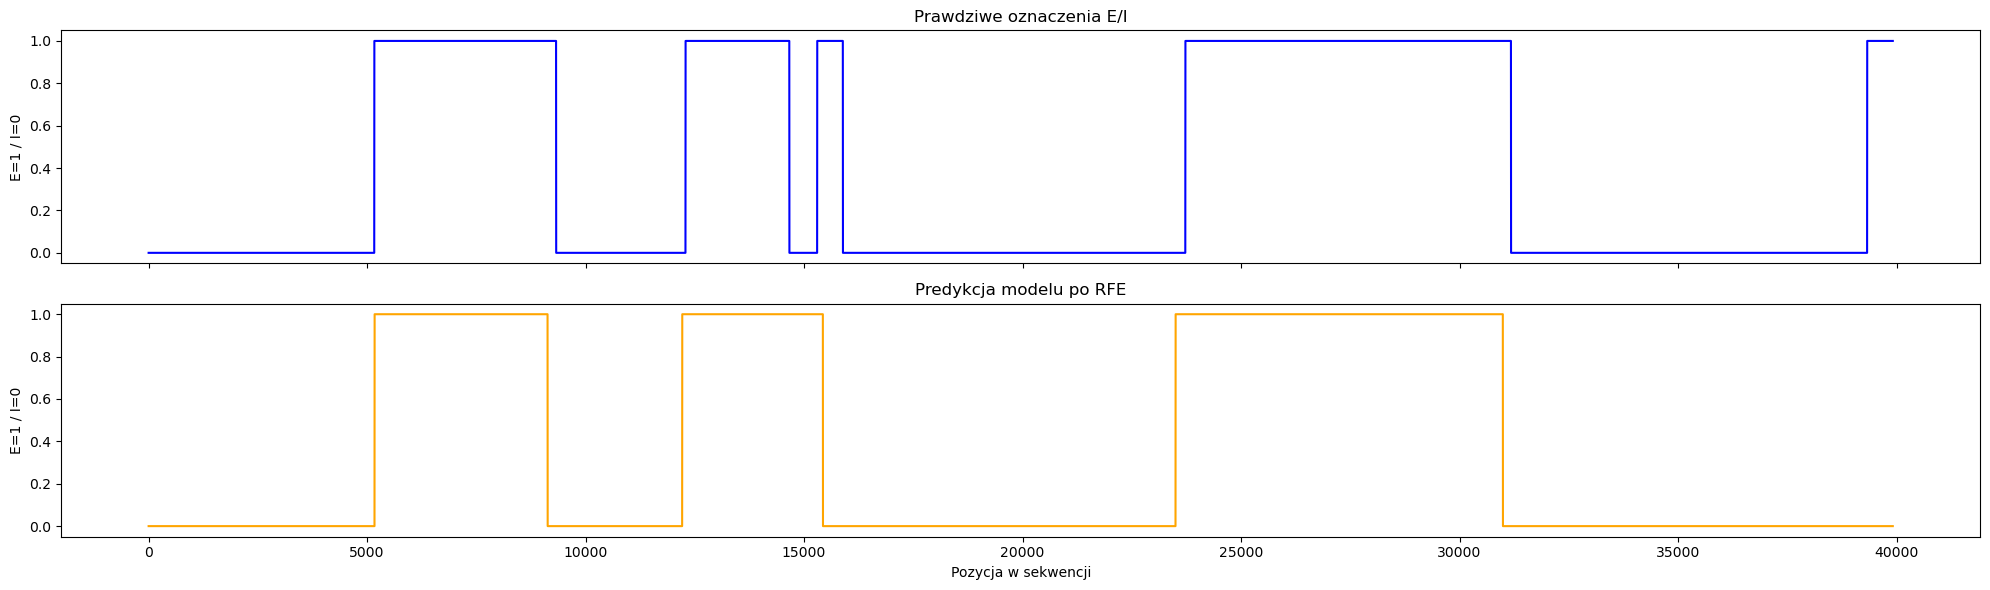

In [258]:
w, s, t = best_params_rfe
preds_rfe = predict_sliding_window_rfe(gene_seq, window=w, step=s)
position_preds_rfe = window_preds_to_positions_rfe(preds_rfe, len(gene_seq), window=w, step=s, threshold=t)
print(sigmoid_accuracy(true_labels, position_preds_rfe))
plot(true_labels, position_preds_rfe)

Check on random gene2

0.9474553842713898


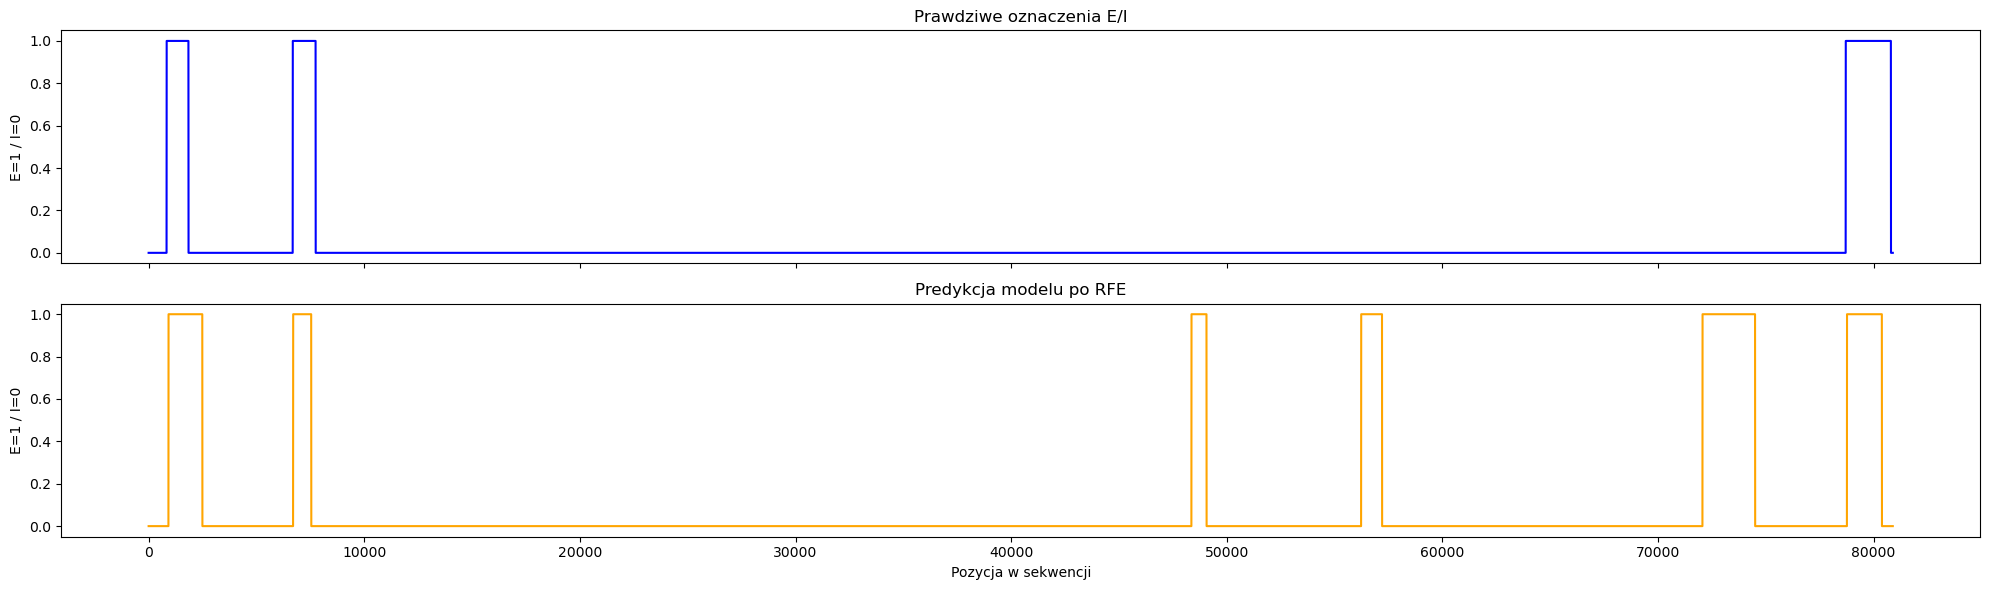

In [272]:
preds_rfe = predict_sliding_window_rfe(gene_seq2, window=w, step=s)
position_preds_rfe = window_preds_to_positions_rfe(preds_rfe, len(gene_seq2), window=w, step=s, threshold=t)
print(sigmoid_accuracy(true_labels2, position_preds_rfe))
plot(true_labels2, position_preds_rfe)

Check on random gene 3

30741 GTGAGGGGCGTGTGGGCAGAGGGGGTTTGGGACAGCAGGGTTTGTGCTAGGGGCTCTGGAGCCTGCCTTGGGTTCTTACAACCTCTCTAAAAAGCCAGGACTGCTCTCATCATTTCAATAGGGAGAAAACTGAGACTCAGAAAGAGAAAGGACTTGCCCTGGGTCGAATTGAAGGTTGGGAGCCTCTGAAGGCTTTTTTA
0.8822997360649015


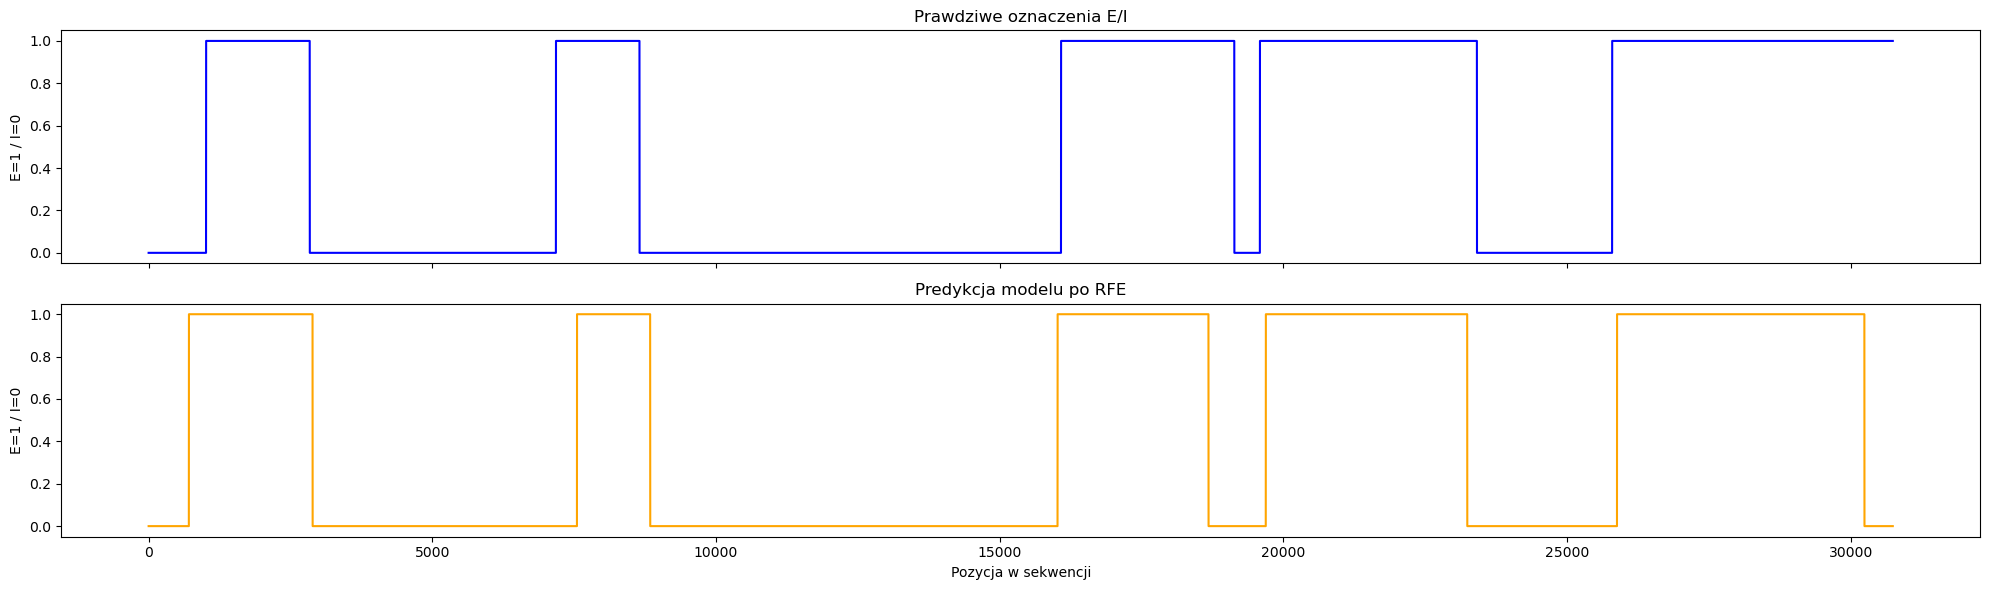

In [279]:
gene_seq3, true_labels3 = generate_random_gene(X_test, y_test)
print(len(gene_seq3), gene_seq3[:200])

preds_rfe = predict_sliding_window_rfe(gene_seq3, window=w, step=s)
position_preds_rfe = window_preds_to_positions_rfe(preds_rfe, len(gene_seq3), window=w, step=s, threshold=t)
print(sigmoid_accuracy(true_labels3, position_preds_rfe))
plot(true_labels3, position_preds_rfe)